# Ejercicio 6

Compara el modelo anterior con un modelo que use convoluciones 2D. Ten en cuenta que has de reordenar los datos para poder usar convoluciones 2D. Compara el resultado en unos datos de test con el resultado del modelo anterior. ¿Obtienes mejoras al utilizar las convoluciones 2D?

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv1D, Conv2D, Flatten, GRU, LSTM, Reshape
from tensorflow.keras import regularizers;

In [4]:
data = yf.download("AMZN AAPL CSCO GOOGL MSFT", period="max")

[*********************100%***********************]  5 of 5 completed


In [7]:
data_close = data["Close"].dropna(how="any")["AMZN"]
data_open = data["Open"].dropna(how="any")

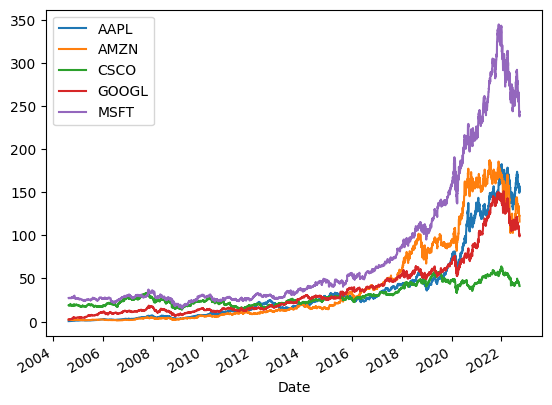

In [8]:
data_open.plot();


In [9]:
#data_open_scale = data_open
#data_close_scale = data_close

#data_open_scale = data_open/data_open.iloc[0,0]
#data_close_scale = data_close/data_close[0]

data_open_scale = np.log(data_open).diff().fillna(1).cumsum()
data_close_scale = np.log(data_close).diff().fillna(1).cumsum()


<AxesSubplot: xlabel='Date'>

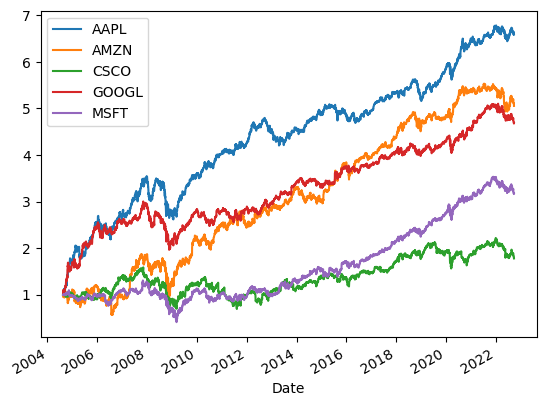

In [10]:
data_open_scale.plot()

In [13]:
batch_size = 4
n_valores = data_open_scale.shape[0] -(data_open_scale.shape[0]%batch_size)
X = data_open_scale.iloc[:n_valores, :].values.reshape(-1, batch_size, 5, 1)
Y = data_close_scale[(batch_size-1):n_valores:batch_size].values

In [16]:
print(X.shape)
Y.shape

(1139, 4, 5, 1)


(1139,)

In [23]:
umbral = int(len(X)*0.9)
X_train, X_test = X[:umbral], X[umbral:]
Y_train, Y_test = Y[:umbral], Y[umbral:]

### Modelo Lineal

In [ ]:
model_lineal = Sequential(name='lineal')
model_lineal.add(Flatten(input_shape=(4,5)))
model_lineal.add(Dense(1))
model_lineal.summary();

Model: "lineal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 20)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt_adam = Adam(learning_rate = 1e-4)
model_lineal.compile(optimizer=opt_adam,
                   loss='mae',
                   metrics=['mse'])

In [ ]:
history = model_lineal.fit(X_train,
                        Y_train,
                        validation_split = 0.2,
                        epochs=1000,
                        batch_size=128)

Epoch 1/1000
7/7 [==============================] - 1s 28ms/step - loss: 4.1690 - mse: 19.2420 - val_loss: 7.5770 - val_mse: 57.7771
Epoch 2/1000
7/7 [==============================] - 0s 9ms/step - loss: 4.1366 - mse: 18.9501 - val_loss: 7.5231 - val_mse: 56.9596
Epoch 3/1000
7/7 [==============================] - 0s 13ms/step - loss: 4.1041 - mse: 18.6601 - val_loss: 7.4692 - val_mse: 56.1484
Epoch 4/1000
7/7 [==============================] - 0s 11ms/step - loss: 4.0717 - mse: 18.3728 - val_loss: 7.4153 - val_mse: 55.3422
Epoch 5/1000
7/7 [==============================] - 0s 18ms/step - loss: 4.0394 - mse: 18.0904 - val_loss: 7.3613 - val_mse: 54.5414
Epoch 6/1000
7/7 [==============================] - 0s 17ms/step - loss: 4.0068 - mse: 17.8032 - val_loss: 7.3076 - val_mse: 53.7497
Epoch 7/1000
7/7 [==============================] - 0s 14ms/step - loss: 3.9744 - mse: 17.5242 - val_loss: 7.2537 - val_mse: 52.9612
Epoch 8/1000
7/7 [==============================] - 0s 14ms/step - los

In [ ]:
score = model_lineal.evaluate(X_test, Y_test)
score

4/4 [==============================] - 0s 2ms/step - loss: 0.1677 - mse: 0.0302


[0.16766665875911713, 0.030248157680034637]

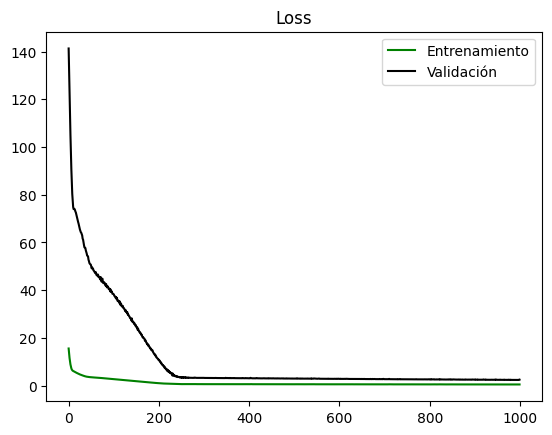

In [ ]:
plt.title("Loss")
plt.plot(history.history['loss'],
         color='green',
         label="Entrenamiento")
plt.plot(history.history['val_loss'],
         color='black',
         label="Validación")
plt.legend()
#plt.yscale("log")

In [35]:
model = Sequential()
model.add(Conv2D(32, 4, input_shape=X_train.shape[1:], padding='same'))
model.add(Reshape(target_shape=(20, 32)))
model.add(LSTM(64, input_shape=(64, 16), return_sequences=True))
model.add(GRU(64, input_shape=(4, 4),
              activation='relu'))
# model.add(Flatten())
model.add(Dense(1))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 4, 5, 32)          544       
                                                                 
 reshape_2 (Reshape)         (None, 20, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 64)            24832     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 50,401
Trainable params: 50,401
Non-trainable params: 0
_________________________________________________________________


In [36]:
opt_adam = Adam(learning_rate = 1e-4)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
model.compile(optimizer=opt_adam,
                            loss='mae',
                            metrics=['mae'],
                            callbacks = [early_stop],)

In [37]:
history = model.fit(X_train,
                                       Y_train,
                                        validation_split = 0.2,
                                        epochs=1000,
                                        batch_size=32)

Epoch 1/1000
26/26 [==============================] - 7s 115ms/step - loss: 2.1829 - mae: 2.1829 - val_loss: 4.2797 - val_mae: 4.2797
Epoch 2/1000
26/26 [==============================] - 2s 61ms/step - loss: 1.6560 - mae: 1.6560 - val_loss: 3.3566 - val_mae: 3.3566
Epoch 3/1000
26/26 [==============================] - 1s 58ms/step - loss: 0.8983 - mae: 0.8983 - val_loss: 2.0050 - val_mae: 2.0050
Epoch 4/1000
26/26 [==============================] - 2s 62ms/step - loss: 0.5908 - mae: 0.5908 - val_loss: 1.4082 - val_mae: 1.4082
Epoch 5/1000
26/26 [==============================] - 1s 57ms/step - loss: 0.4514 - mae: 0.4514 - val_loss: 0.9113 - val_mae: 0.9113
Epoch 6/1000
26/26 [==============================] - 2s 61ms/step - loss: 0.3083 - mae: 0.3083 - val_loss: 0.4078 - val_mae: 0.4078
Epoch 7/1000
26/26 [==============================] - 2s 59ms/step - loss: 0.2082 - mae: 0.2082 - val_loss: 0.0997 - val_mae: 0.0997
Epoch 8/1000
26/26 [==============================] - 2s 76ms/step -

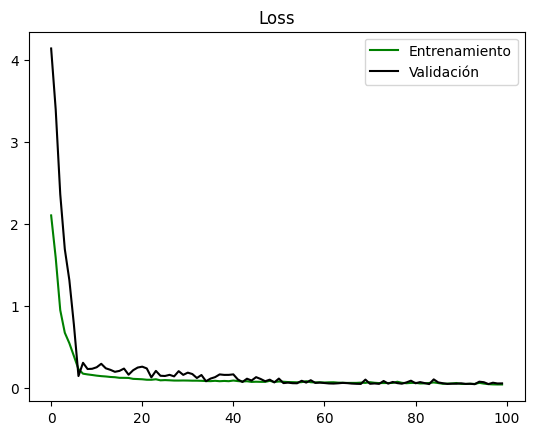

In [28]:
plt.title("Loss")
plt.plot(history.history['loss'],
         color='green',
         label="Entrenamiento")
plt.plot(history.history['val_loss'],
         color='black',
         label="Validación")
plt.legend()
#plt.yscale("log")

In [29]:
score = model.evaluate(X_test, Y_test)
score

4/4 [==============================] - 0s 9ms/step - loss: 0.0975 - mae: 0.0975


[0.0975225493311882, 0.0975225493311882]

In [30]:
y_hat = model.predict(X_train)

33/33 [==============================] - 2s 12ms/step


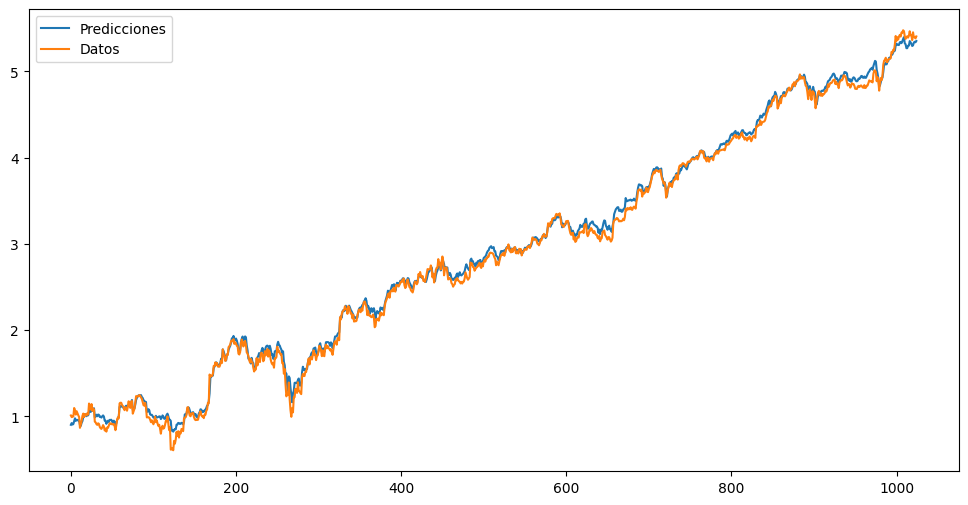

In [31]:
plt.figure(figsize=(12,6))
plt.plot(y_hat, label="Predicciones")
plt.plot(Y_train, label="Datos")
plt.legend()

In [32]:
y_hat_test = model.predict(X_test)

4/4 [==============================] - 0s 14ms/step


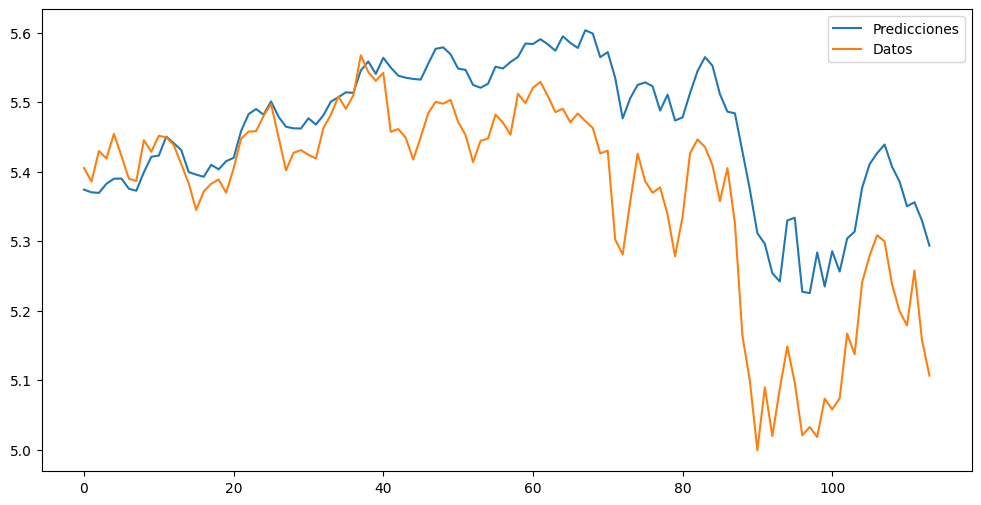

In [33]:
plt.figure(figsize=(12,6))
plt.plot(y_hat_test, label="Predicciones")
plt.plot(Y_test, label="Datos")
plt.legend()

In [34]:
y_hat = model_lineal.predict(X_test)

NameError: name 'model_lineal' is not defined

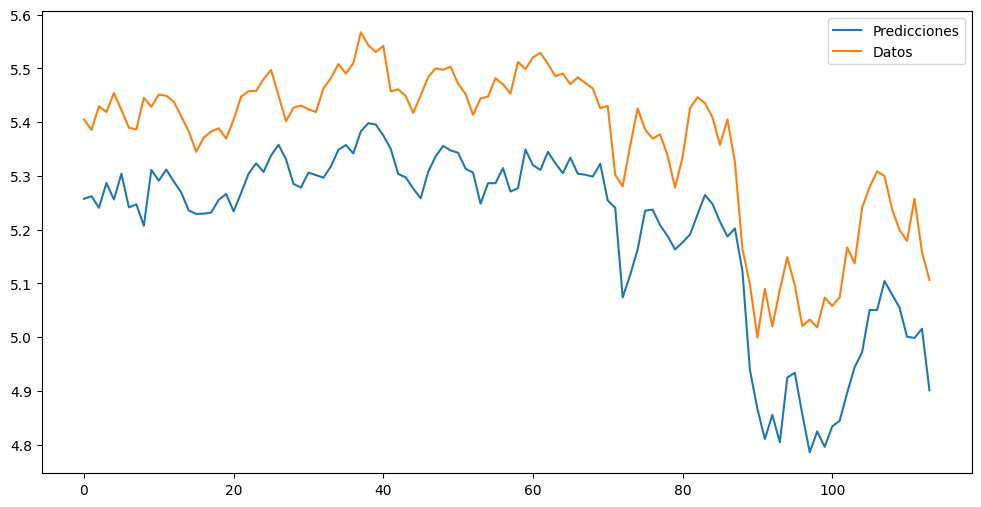

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_hat, label="Predicciones")
plt.plot(Y_test, label="Datos")
plt.legend()